In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
import torch
from pennylane import numpy as np
from torch.autograd import Variable
import torch.optim as optim

num_classes = 3
margin = 0.15
feature_size = 4
batch_size = 10
lr_adam = 0.01
train_split = 0.75
num_qubits = 2
num_layers = 6
total_iterations = 100

dev = qml.device("default.qubit", wires=num_qubits)

In [3]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [4]:
def circuit(weights, feat=None):
    qml.templates.embeddings.AmplitudeEmbedding(feat, [0, 1], pad=0.0, normalize=True)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

qnode1 = qml.QNode(circuit, dev).to_torch()
qnode2 = qml.QNode(circuit, dev).to_torch()
qnode3 = qml.QNode(circuit, dev).to_torch()

In [5]:
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

In [6]:
def multiclass_svm_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        # Compute the score given to this sample by the classifier corresponding to the
        # true label. So for a true label of 1, get the score computed by classifer 1,
        # which distinguishes between "class 1" or "not class 1".
        s_true = variational_classifier(
            q_circuits[int(true_labels[i])],
            (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
            feature_vec,
        )
        s_true = s_true.float()
        li = 0

        # Get the scores computed for this sample by the other classifiers
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(
                    q_circuits[j], (all_params[0][j], all_params[1][j]), feature_vec
                )
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

In [7]:
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = [0, 0, 0]
        for c in range(num_classes):
            score = variational_classifier(
                q_circuits[c], (all_params[0][c], all_params[1][c]), feature_vec
            )
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels

def accuracy(labels, hard_predictions):
    loss = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / labels.shape[0]
    return loss

In [18]:
def load_and_process_data():
    data = np.genfromtxt("iris.csv", delimiter=",")
    X = torch.tensor(data[:, 0:feature_size])
    print("First X sample (original)  :", X[0])

    # normalize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)
    print("First X sample (normalized):", X_norm[0])

    Y = torch.tensor(data[:, -1])
    return X, Y

# Create a train and test split. Use a seed for reproducability
def split_data(feature_vecs, Y):
    np.random.seed(0)
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train, feat_vecs_test, Y_train, Y_test

First X sample (original)  : tensor([5.1000, 3.5000, 1.4000, 0.2000], dtype=torch.float64)
First X sample (normalized): tensor([0.8038, 0.5516, 0.2206, 0.0315], dtype=torch.float64)
Num params:  111
Iter:     1 | Cost: 0.3225268 | Acc train: 0.3214286 | Acc test: 0.3684211 
Iter:     2 | Cost: 0.2043319 | Acc train: 0.3303571 | Acc test: 0.3684211 
Iter:     3 | Cost: 0.2489223 | Acc train: 0.3660714 | Acc test: 0.3947368 
Iter:     4 | Cost: 0.2462631 | Acc train: 0.3750000 | Acc test: 0.4473684 
Iter:     5 | Cost: 0.1970864 | Acc train: 0.3928571 | Acc test: 0.5000000 
Iter:     6 | Cost: 0.2739525 | Acc train: 0.3660714 | Acc test: 0.3684211 
Iter:     7 | Cost: 0.2417585 | Acc train: 0.3928571 | Acc test: 0.3947368 
Iter:     8 | Cost: 0.1941588 | Acc train: 0.5000000 | Acc test: 0.4473684 
Iter:     9 | Cost: 0.1191929 | Acc train: 0.5625000 | Acc test: 0.5526316 
Iter:    10 | Cost: 0.2571387 | Acc train: 0.6250000 | Acc test: 0.6315789 
Iter:    11 | Cost: 0.2574309 | Acc train

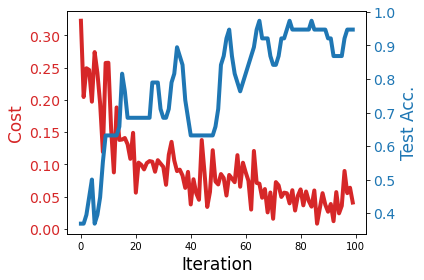

In [19]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = [qnode1, qnode2, qnode3]

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []

    # train the variational classifier
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc


# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required

features, Y = load_and_process_data()
costs, train_acc, test_acc = training(features, Y)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()